# 9. Extreme Gradient Boosting (XGBoost)

XGBoost is an **ensemble model** (combine the predictions of multiple individual models to increase robustness), in particular it is a **gradient-boosting algorithm** (multiple weak models are trained sequentially and on different versions of the datasets, and each model tries to correct the errors made by the previous models. The final prediction is made by weighted voting)

Like Random Forest, it can be used for both regression and classification. It has gained significant popularity due to its exceptional performance in predictive modeling competitions and real-world applications. 

XGBoost is particularly effective in handling structured/tabular data and is known for its robustness, scalability, and ability to capture complex patterns.

## Overview
1. How XGBoost Works
    * 1.1 Hyperparameters in XGBoost
    * 1.2 When to use XGBoost? When not to use?
2. Assumptions
3. Common Pitfalls
4. Implementation example
    * 4.1 Regression
    * 4.2 Classification
    * 4.3 XGBoost Native vs. XGBoost Sklearn
    * 4.4 **usecase**: Hourly energy consumption Time Series Forecasting using XGBoost

## 1. How XGBoost Works

XGBoost builds a predictive model by combining the predictions of multiple individual models, often decision trees, in an iterative manner. Each predictor corrects its predecessor’s error.

Core principles:
* **Gradient Boosting**: XGBoost employs gradient boosting, which involves minimizing a loss function by iteratively adding new models to the ensemble. It uses a **gradient descent optimization** technique to minimize a predefined loss function during training.

* **Regularization**: XGBoost incorporates L1 (lasso) and L2 (ridge) regularization terms into the loss function to control overfitting.

* **Feature Importance or data weighing**: XGBoost provides insights into feature importance, allowing you to understand the contribution of each feature to the model’s predictions.

* **Cross-validation**: XGBoost supports k-fold cross-validation to evaluate and optimize
model performance.

### 1.1. Hyperparameters in XGBoost
XGBoost has a wide range of hyperparameters that can be tuned to optimize model performance. Here are some of the most important hyperparameters:

| Hyperparameter | Description | Default Value |
| --- | --- | --- |
| n_estimators | controls the number of trees in the model. Increasing this value generally improves model performance, but can also lead to overfitting. | 100 - 1000 |
| Eta (learning rate) | The learning rate controls the step size at which the optimizer makes updates to the weights. A smaller eta value results in slower but more accurate updates, while a larger eta value results in faster but less accurate updates. | It is common to start with a relatively high (0.3) value and then gradually decrease it. |
| max_depth | controls the maximum depth of the trees in the model. A larger max_depth value results in more complex models, which can lead to overfitting.| Common starting values for max_depth are between 3 and 10. |
| subsample | controls the fraction of observations used for each tree. A smaller subsample value results in smaller and less complex models, which can help prevent overfitting. A larger subsample value results in larger and more complex models, which can lead to overfitting. | It is common to set this value between 0.5 and 1. |
| lambda | L2 regularization term on weights. Larger values means more conservative model, it helps to reduce overfitting by adding a penalty term to the loss function. | Common starting values are small, eg 1, and increase gradually. |
| alpha | L1 regularization term on weights. Larger values means more conservative model, it helps to reduce overfitting by adding a penalty term to the loss function. | Common starting values are small, eg 0, and increase gradually. |
| objective |  the loss function to be minimized. For example, ‘binary:logistic’ for binary classification or ‘reg:squarederror’ for regression problem.| ‘reg:squarederror’ or ‘binary:logistic’ |
| eval_metric | the metric used for monitoring performance during training and for early stopping. | eg: ‘auc’ for area under the ROC curve, ‘rmse’ for root mean square error. |



### 1.2. When to use XGBoost? When not to use?
* Tabular data
* Large datasets
* High-dimensional data (it enforces feature selection)
* With imbalanced datasets. XGBoost offers hyperparameters, such as `scale_pos_weight`, which can be used to address class imbalance in the data, making it effective for imbalanced classification problems.

## 2. Assumptions
Similar to random forest, XGBoost is an ensemble learning algorithm based on decision trees and has
fewer assumptions compared to traditional linear models. Thus, the same practical considerations
mentioned for Random Forest should also be considered here.

* **Independence of features**: Decision trees assume that features are independent of each other. However, this assumption is less critical in random forests because each tree is trained on a different subset of features.

* **Linear relationships**: Decision trees assume that the relationships between features and the target variable are linear. Random forest, being an ensemble of decision trees, can capture both linear and nonlinear relationships in the data due to the diversity of trees it comprises.

* **Homoscedasticity**: Decision trees do not make explicit assumptions about the homoscedasticity (constant variance) of errors. Similarly, random forest, being a combination of decision trees, is not directly affected by this assumption.

* **Normality of residuals**: Decision trees do not rely on the assumption of normality of residuals, and the random forest algorithm inherits this flexibility. However, if you’re using random forest as part of a broader analysis that assumes normality (for example, hypothesis testing), you should consider this aspect in your overall approach.

* **Feature scaling**: Random forest is relatively insensitive to the scale of features. It doesn’t require features to be standardized or normalized, unlike some other algorithms, such as gradient
boosting or K-means clustering.

* **Multicollinearity**: Random forest can handle multicollinearity (high correlation between features) because it selects a random subset of features at each split. This helps to reduce the impact of correlated features on the model’s performance.

## 3. Common Pitfalls

While XGBoost is a powerful algorithm, there are some considerations to keep in mind:

* **Hyperparameter tuning**: The performance of XGBoost can be sensitive to hyperparameters. Careful tuning is essential for optimal results.
* **Overfitting**: Despite regularization, overfitting can still occur, especially when using a large number of boosting rounds.
* **Computational complexity**: Complex models or large datasets can lead to increased computational demands and longer training times.
* **Interpretability**: While XGBoost provides feature importance, its complex nature may make model interpretation challenging.

## 4. Implementation example

We will use the Diamonds dataset, whic is included in the seaborn library. The goal is to predict the price of a diamond based on its characteristics.

About the data:

* carat: weight of the diamond (0.2--5.01)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond colour, from J (worst) to D (best)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* Depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* table: width of top of diamond relative to widest point (43--95)
* price: price in US dollars (\$326--\$18,823)
* x: length in mm (0--10.74)
* y: width in mm (0--58.9)
* z: depth in mm (0--31.8)


In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import OrdinalEncoder

plt.style.use('fivethirtyeight')

In [2]:
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
print(diamonds.shape)
diamonds.describe()

(53940, 10)


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [4]:
diamonds.describe(exclude=np.number)  # exclude numerical columns

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


### 4.1. Regressopn example - predicting diamond prices

In [5]:
# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

The dataset has three categorical columns. 

Normally, you would encode them with ordinal or one-hot encoding, but XGBoost has the ability to internally deal with categoricals.

The way to enable this feature is to cast the categorical columns into Pandas category data type (by default, they are treated as text columns):

In [6]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

print(X.dtypes)

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object


In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

XGBoost comes with its own class for storing datasets called DMatrix. It is a highly optimized class for memory and speed. That's why converting datasets into this format is a requirement for the native XGBoost API.

To enable automatic encoding of Pandas category columns, we also set enable_categorical to True.

In [8]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

After building the DMatrices, you should choose a value for the objective parameter. It tells XGBoost the machine learning problem you are trying to solve and what metrics or loss functions to use to solve that problem.

For regression, it is common to use Root Mean Squared Error, which minimizes the square root of the squared sum of the differences between actual and predicted values. 

**Note:** difference between loss function and metric:
* a **loss function** should be **minimized** (differences between the actual (ground truth) values and model predictions)
* **metric** should be **maximized** (measure the similarity between ground truth and model predictions).

In [9]:
# The chosen objective function and any other hyperparameters of XGBoost should be 
# specified in a dictionary, which by convention should be called params:
params = {"objective": "reg:squarederror",  # Specify the regression objective
         } # "tree_method": "gpu_hist"}  # Use GPU acceleration

# Train the model
n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,  # Number of boosting rounds, another parameter.
)

# Evaluation
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")


RMSE of the base model: 552.861


We can use evaluation arrays to see model performance as it gets improved incrementally across boosting rounds.

In [10]:
params = {"objective": "reg:squarederror",  # Specify the regression objective
         } # "tree_method": "gpu_hist"}  # Use GPU acceleration

# we create a list of two tuples that each contain two elements. 
# The first element is the array for the model to evaluate, 
# The second is the array’s name.
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

n = 10000  # In real-world projects, >1000 is common, but we should start at 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50, # Show evaluation very ten rounds
   early_stopping_rounds=50,  # Stop if the validation score hasn't improved in 50 rounds
)

[0]	train-rmse:2874.49146	validation-rmse:2817.90814
[50]	train-rmse:438.68033	validation-rmse:554.13365
[100]	train-rmse:381.96310	validation-rmse:553.73941
[128]	train-rmse:358.11000	validation-rmse:553.05030


There are two ways we can improve it— by performing cross-validation and hyperparameter tuning.

Lets see how to do cross-validation with XGBoost.

At the beginning of the tutorial, we set aside 25% of the dataset for testing. The test set would allow us to simulate the conditions of a model in production, where it must generate predictions for unseen data.

But only a single test set would not be enough to measure how a model would perform in production accurately. That's why we use cross-validation. We want a model that performs well on any test set we throw at it.

A possible workaround is splitting the data into three sets. The model trains on the first set, the second set is used for evaluation and hyperparameter tuning, and the third is the final one we test the model before production.

But when data is limited, splitting data into three sets will make the training set sparse, which hurts model performance.

The solution to all these problems is cross-validation. In cross-validation, we still have two sets: training and testing.

While the test set waits in the corner, we split the training into 3, 5, 7, or k splits or folds. Then, we train the model k times. Each time, we use k-1 parts for training and the final kth part for validation. This process is called k-fold cross-validation:

<img src="https://images.datacamp.com/image/upload/v1677079701/Cross_validation_65db22d38c.png" width=700>

In [11]:
params = {"objective": "reg:squarederror",  # Specify the regression objective
         } # "tree_method": "gpu_hist"}  # Use GPU acceleration


n = 1000  # In real-world projects, >1000 is common, but we should start at 100

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,  # 5-fold cross-validation.
   early_stopping_rounds=20
)

# After all folds are done, we can take the mean of the scores as the final result.
best_rmse = results['test-rmse-mean'].min()

print("score:", best_rmse)
results.head()

score: 550.2735543625861


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2874.224552,9.424846,2876.318793,36.995997
1,2088.350837,7.595382,2093.063623,25.351925
2,1552.629638,4.974140,1560.552731,19.550836
3,1185.994963,4.133544,1198.669943,14.648669
4,943.402904,4.757288,962.349383,11.724038


Note that this method of cross-validation is used to see the true performance of the model. Once satisfied with its score, you must retrain it on the full data before deployment.

### 4.2. Classification example - predicting diamond cut
The two most popular classification objectives are:

* **binary:logistic** - **binary classification** (the target contains only two classes, i.e., cat or dog)
* **multi:softprob** - **multi-class classification** (more than two classes in the target, i.e., apple/orange/banana)

We want to predict the cut quality of diamonds given their price and their physical measurements. So, we will build the feature/target arrays accordingly:

In [12]:
X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
   X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

# Create classification matrices or DMatrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [13]:
params = {"objective": "multi:softprob", # Multiclass classification
          # "tree_method": "gpu_hist", 
          "num_class": 5}
n = 1000

# Cross-validation
results = xgb.cv(
   params, 
   dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["mlogloss", "auc", "merror"],  # watch three classification metrics
)

In [14]:
print(results.keys())

# To see the best AUC score, we take the maximum of test-auc-mean column:
results['test-auc-mean'].max()

Index(['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean',
       'train-auc-std', 'train-merror-mean', 'train-merror-std',
       'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean',
       'test-auc-std', 'test-merror-mean', 'test-merror-std'],
      dtype='object')


0.9403142471581767

In [15]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

# train the model
model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=[(dtrain_clf, "train"), (dtest_clf, "validation")],
   verbose_eval=50,
   early_stopping_rounds=20,
)

[0]	train-mlogloss:1.25764	validation-mlogloss:1.26400
[50]	train-mlogloss:0.46532	validation-mlogloss:0.57336
[100]	train-mlogloss:0.36724	validation-mlogloss:0.54234
[150]	train-mlogloss:0.31199	validation-mlogloss:0.53715
[181]	train-mlogloss:0.28451	validation-mlogloss:0.53669


### 4.3. XGBoost Native vs. XGBoost Sklearn

So far, we have been using the native XGBoost API, but its Sklearn API is pretty popular as well.

Sklearn is a vast framework with many machine learning algorithms and utilities and has an API syntax loved by almost everyone. Therefore, XGBoost also offers XGBClassifier and XGBRegressor classes so that they can be integrated into the Sklearn ecosystem (at the loss of some of the functionality).

After training the XGBoost classifier or regressor, you can convert it using the get_booster method:

In [16]:
# Train a model using the scikit-learn API
xgb_classifier = XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

# Convert the model to a native API model
model = xgb_classifier.get_booster()  # The model object will behave like a native API model

### 4.4 Hourly energy consumption Time Series Forecasting using XGBoost

The data we will be using is hourly power consumption data from PJM from 2002-2018 for the entire east regionof the US.

We will use 2002-2014 as our training data and 2015-2018 as our test and validation data.

Features:
* Datetime
* estimated energy consumption in Megawatts (MW)

In [25]:
df = pd.read_csv('../data/PJME_hourly.csv/PJME_hourly.csv', index_col=[0], parse_dates=[0])
df.head()  # index = datetime, only feature = PJME_MW

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


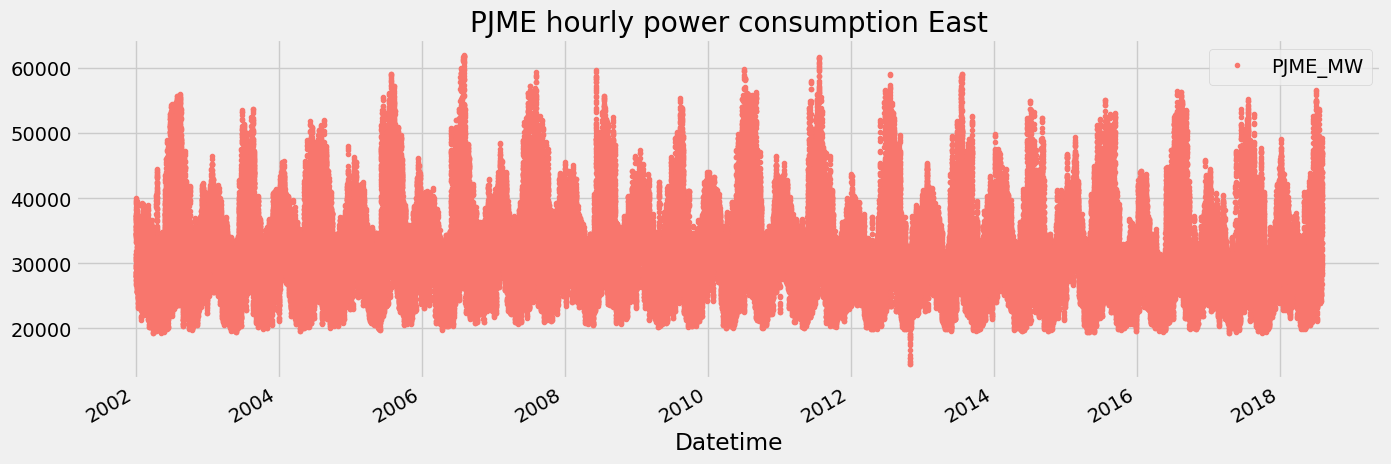

In [27]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME hourly power consumption East')

"\n_ = df_test     .rename(columns={'PJME_MW': 'TEST SET'})     .join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer')     .plot(figsize=(15,5), title='PJM East', style='.')   \n"

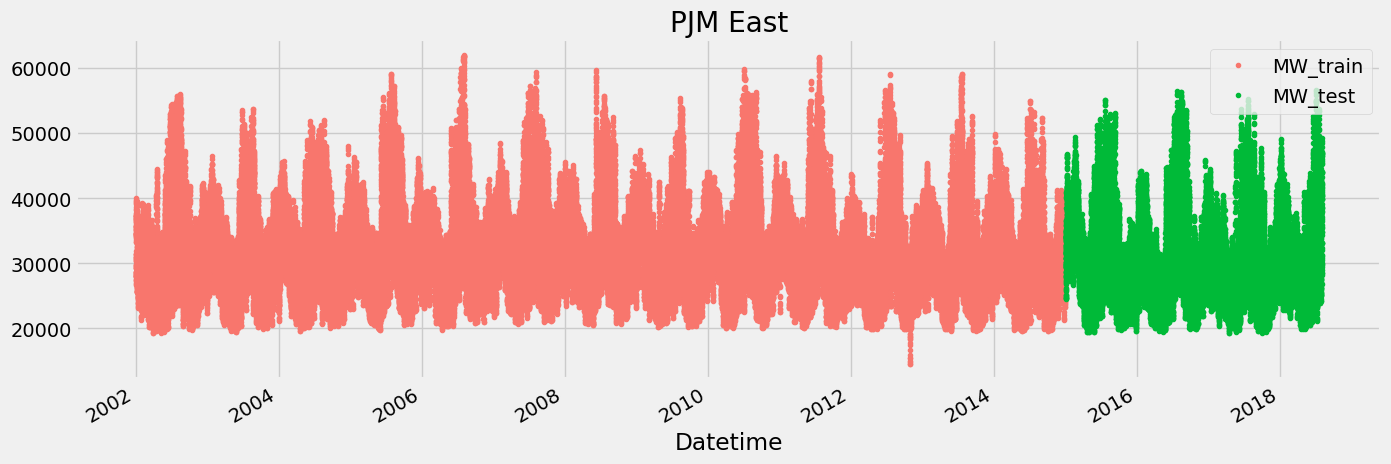

In [28]:
split_date = '01-Jan-2015'
df_train = df.loc[df.index <= split_date].copy()  # Since the datatype is datetime, we can use operators like <=
df_test = df.loc[df.index > split_date].copy()  # if it wasent in datetime datatype: df.index.dt.to_timestamp()

# rename columns to test and train
df_train.rename(columns={'PJME_MW':'MW_train'}, inplace=True)
df_test.rename(columns={'PJME_MW':'MW_test'}, inplace=True)

# Plot the training and test sets in the same plot
df_train['MW_train'].plot(figsize=(15,5), title='PJM East', color=color_pal[0], legend=True, style='.')
df_test['MW_test'].plot(color=color_pal[3], legend=True, style='.')

#More efficient coding:
"""
_ = df_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')   
"""

Create time series features

In [29]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index

    Args:
        df: pandas dataframe with datetime index
        label: name of column to use as label

    Returns:
        x: dataframe with features
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(df_train, label='MW_train')
X_test, y_test = create_features(df_test, label='MW_test')

# Easy visualization of the training
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


Create XGBoos Model

In [34]:
reg = XGBRegressor(n_estimators=100,
                   max_depth=6,
                   learning_rate=0.1,
                   early_stopping_rounds=20)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

# Evaluation
preds = reg.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

[0]	validation_0-rmse:6009.28320	validation_1-rmse:6112.08282
[20]	validation_0-rmse:3181.13969	validation_1-rmse:3842.46107
[40]	validation_0-rmse:2783.59555	validation_1-rmse:3774.36903
[52]	validation_0-rmse:2614.40267	validation_1-rmse:3799.64561
RMSE of the base model: 3760.702


Check feature importances:

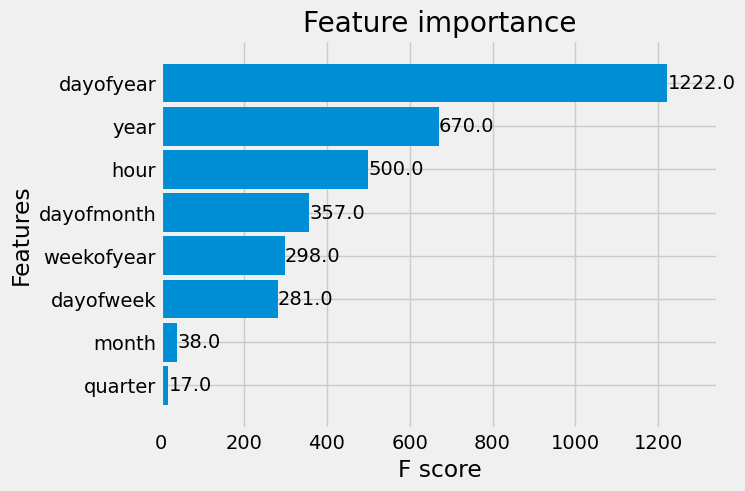

In [35]:
_ = plot_importance(reg, height=0.9)

Forecast (make predictions) on test set:

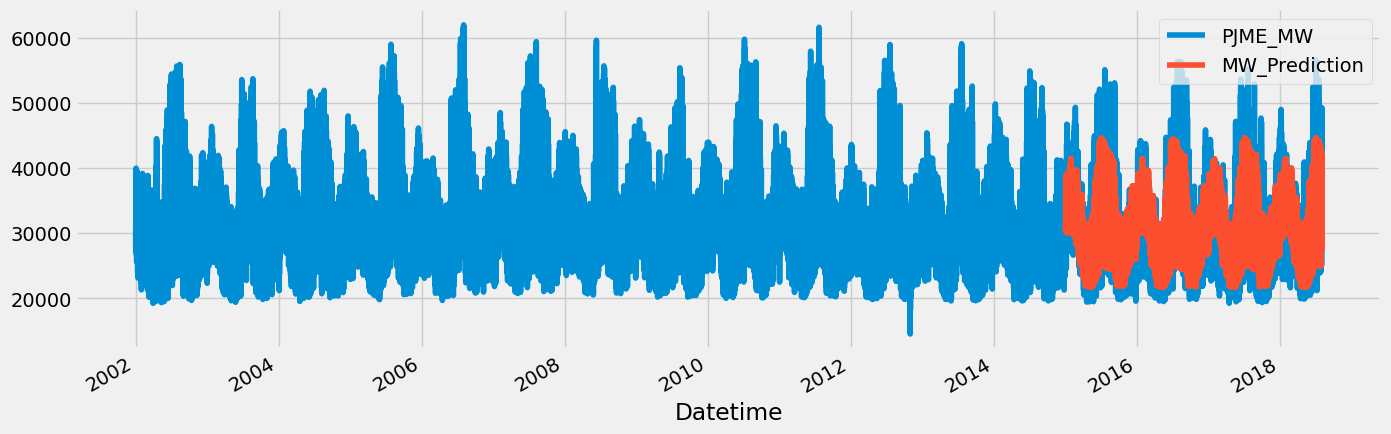

In [36]:
df_test['MW_Prediction'] = reg.predict(X_test)

# Change the column name so we can concatenate the dataframes
df_test.rename(columns={'MW_test': 'PJME_MW'}, inplace=True)
df_train.rename(columns={'MW_train': 'PJME_MW'}, inplace=True)

df_all = pd.concat([df_test, df_train], sort=False)

_ = df_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

Inspect first month of predictions:

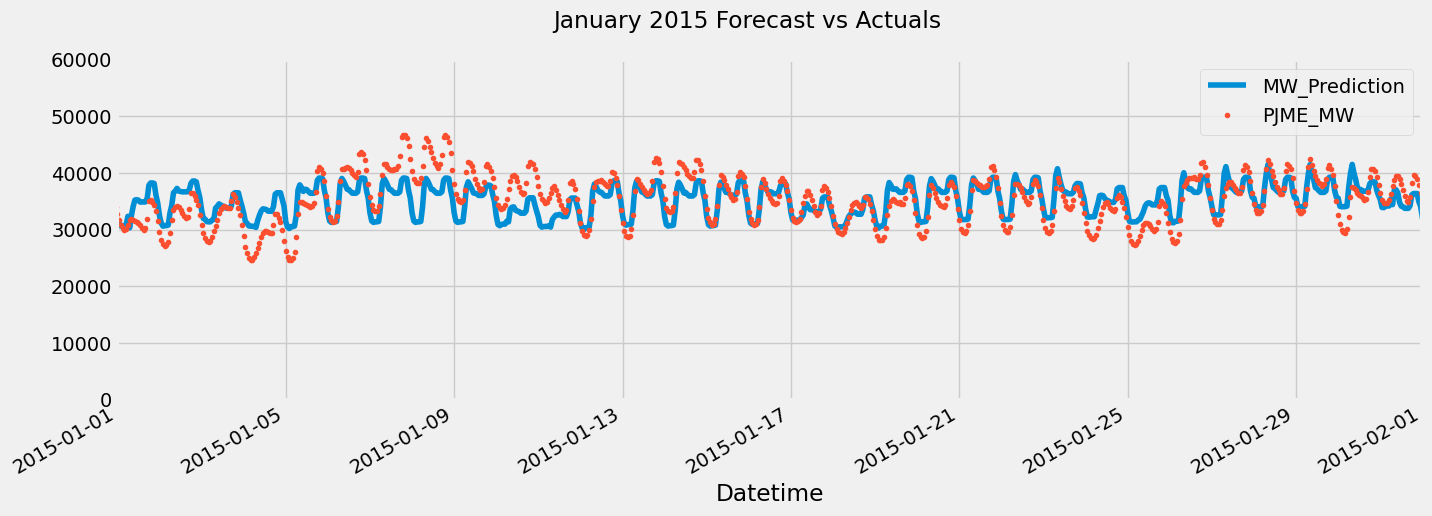

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

Inspect first week of predictions:

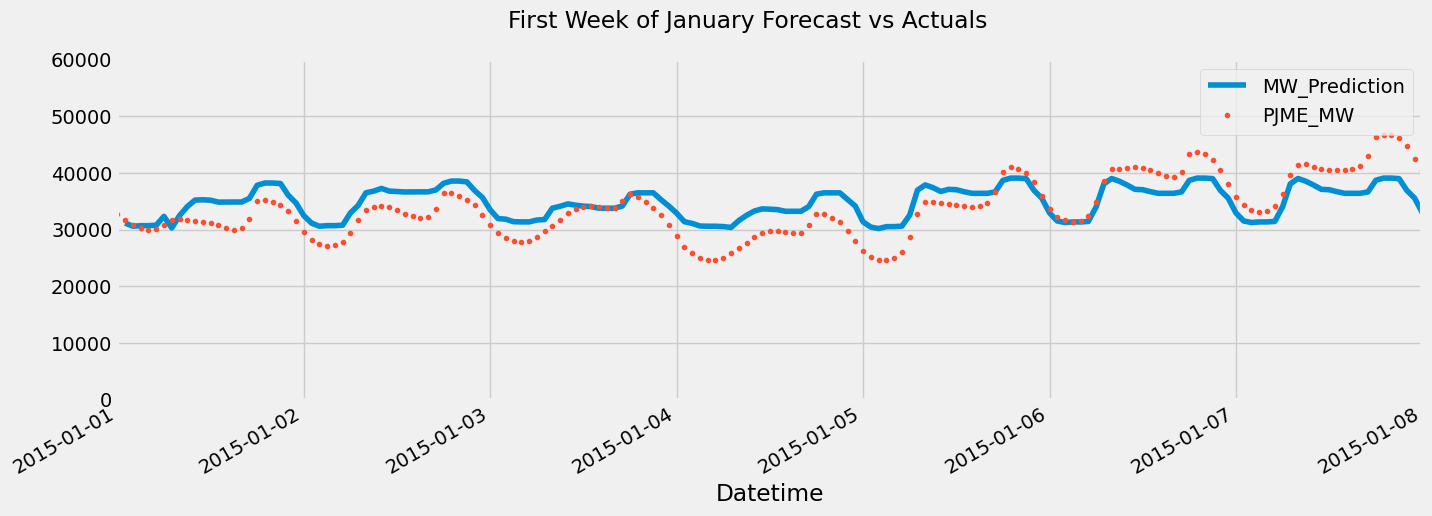

In [38]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

Lets also inspect, for example the first week July of 2015:

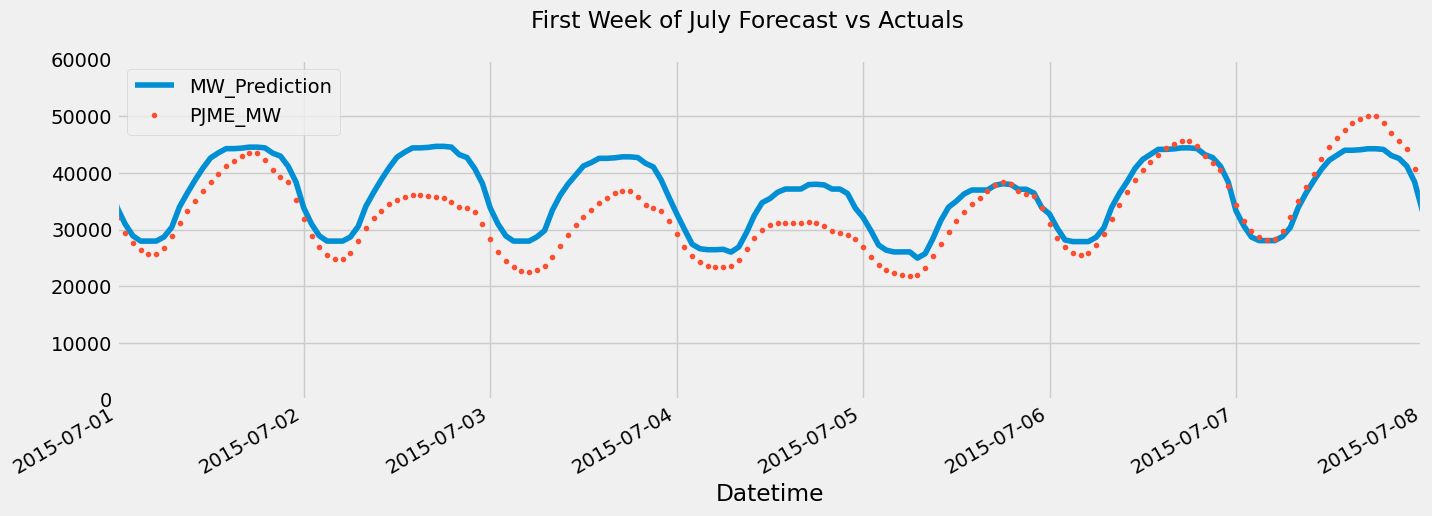

In [39]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

Compute error metrics on test dataset

In [40]:
mean_squared_error(y_true=df_test['PJME_MW'],
                   y_pred=df_test['MW_Prediction'])

14142878.919370065

In [41]:
mean_absolute_error(y_true=df_test['PJME_MW'],
                   y_pred=df_test['MW_Prediction'])

2913.6831209221627

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                   y_pred=df_test['MW_Prediction'])

9.270827027061594

9.27% MAPE means that the model's predictions are off by 9.27% on average.

Lets now look at Worst and Best Predicted Days

In [43]:
df_test['error'] = df_test['PJME_MW'] - df_test['MW_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [44]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37505.246094 -9105.289388  9105.289388
2017 2     24          26445.083333   34837.683594 -8392.600911  8392.600911
     9     1           27280.500000   35588.972656 -8308.474854  8308.474854
           2           24201.458333   32446.068359 -8244.610270  8244.610270
     2     25          24344.458333   32550.197266 -8205.738607  8205.738607
     5     29          24528.416667   32523.369141 -7994.952148  7994.952148
     9     4           26552.416667   34189.289062 -7636.871582  7636.871582
2015 12    25          24466.083333   31913.130859 -7447.047038  7447.047038
2017 2     28          28297.875000   35666.386719 -7368.512858  7368.512858
           20          27070.583333   34384.882812 -7314.298991  7314.298991

Notice anything about the over forecasted days?

* #1 worst day - July 4th, 2016 - is a holiday.
* #3 worst day - December 25, 2015 - Christmas
* #5 worst day - July 4th, 2016 - is a holiday.
Looks like our model may benefit from adding a holiday indicator.

In [45]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31414.585938  13771.246419  13771.246419
           14          44427.333333   30731.810547  13695.524089  13695.524089
     9     10          40996.166667   30017.937500  10978.228760  10978.228760
2015 2     20          44694.041667   34230.707031  10463.331950  10463.331950
2016 8     12          45724.708333   35307.769531  10416.941081  10416.941081
     9     9           43836.958333   33455.863281  10381.093669  10381.093669
2018 1     6           43565.750000   33245.687500  10320.062988  10320.062988
           7           42159.708333   32635.187500   9524.522135   9524.522135
2017 5     19          38032.583333   28590.273438   9442.309326   9442.309326
2015 2     16          43949.500000   34569.410156   9380.090658   9380.090658

The best predicted days seem to be in months where there are not many holidays and mild weather.

In [46]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 1     12          35334.041667   35430.722656  -96.682699  282.514730
     12    30          32213.458333   32445.833984 -232.373698  393.623698
     10    27          28611.166667   28826.677734 -215.510579  411.495443
     4     4           28944.125000   29126.525391 -182.399984  430.411051
2017 5     2           28546.916667   28831.974609 -285.056803  435.980794
     10    24          28657.416667   28830.070312 -172.653158  496.223470
2015 10    28          28500.958333   28830.070312 -329.111491  518.322266
2018 3     27          31483.000000   31288.796875  194.203776  524.999837
2017 12    8           32779.291667   32972.886719 -193.592529  556.395589
2015 3     31          30182.208333   29868.904297  313.303874  567.824382

Lets plot some best/worst predicted days

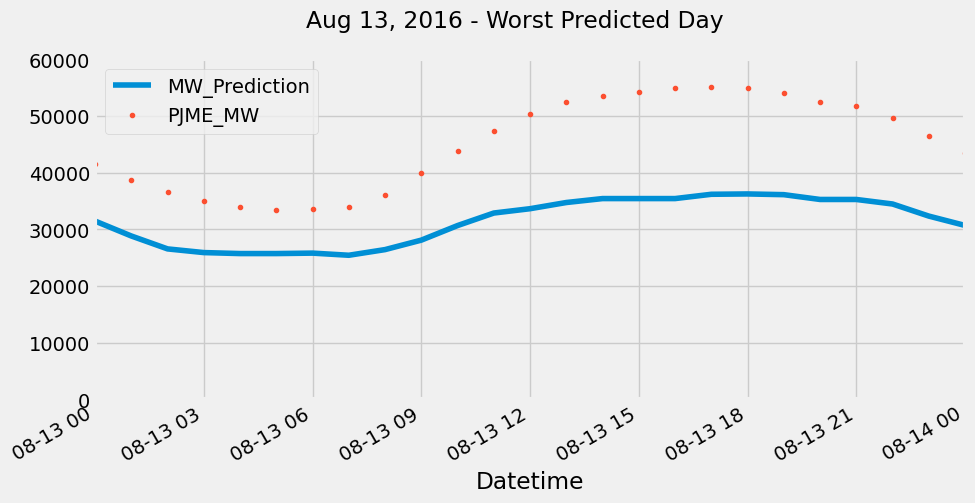

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

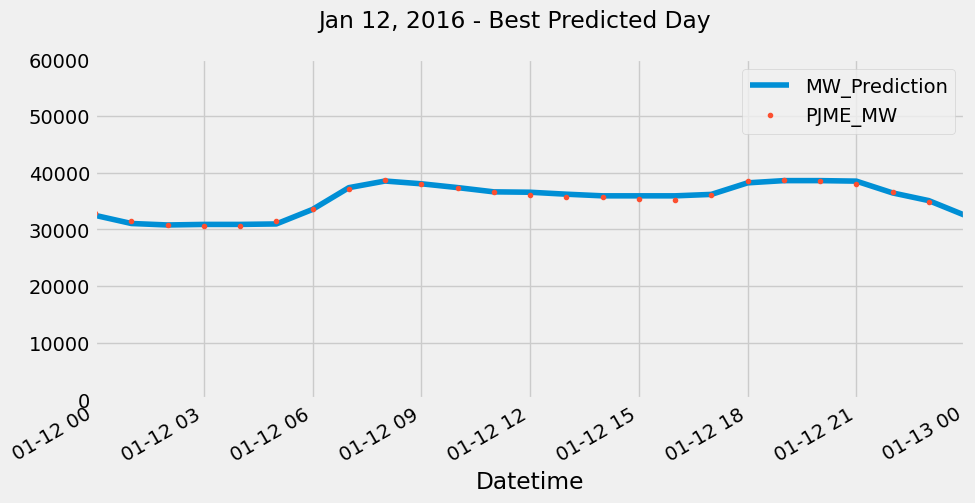

In [48]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-12-2016', upper='01-13-2016')
plot = plt.suptitle('Jan 12, 2016 - Best Predicted Day')

How could we improve our model?
* Add Lag variables
* Add holiday indicators.
* Add weather data source.

Another good training dataset would be: https://shivang-ahd.medium.com/predict-future-sales-kaggle-competition-68061ef7abb5 